# EV State-Space Model

This  notebook is used to reproduce the State Space Model of aggregateed EV for frequency regulation.

Running on Jinning's local machine, in the env "ev".

Working notes:

02/06/2022: the EV data generation is completed. It looks weired, we may need update it later on.


In [7]:
import andes
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)

print(f"ANDES Version: {andes.__version__}")

ANDES Version: 1.6.5.post60+ga84a2f4e


## EV data

### Define parameters

The EV parameters are defined as two types. Type I follows uniform distribution, which is stored in a Dict `ev_param`. Type II follows normal distribution, which is stored in a pd.DataFrame `ev_pdf`.

The data are cited from:

M. Wang et al., "State Space Model of Aggregated Electric Vehicles for Frequency Regulation," in IEEE Transactions on Smart Grid, vol. 11, no. 2, pp. 981-994, March 2020, doi: 10.1109/TSG.2019.2929052.

In [105]:
import scipy.stats as stats


def find_x(x, soc_intv):
    for idx in soc_intv.keys():
        if x >= soc_intv[idx][0] and x <= soc_intv[idx][1]:
            return idx


class ev_ssm():
    """
    EV State Space Model.

    For now, only possible online EV will be kept after initialization.

    EV parameters:
    P, n, En follow uniform distribution.

    Attributes
    ----------
    ev: pandas.DataFrame
        EV dataset: (kW, kWh, h)
        'Pc', 'Pd', 'nc', 'nd', 'En', 'soci', 'socd', 'ts', 'tf',

        'socx', current soc interval
    N: int
        Total number of EVs
    n: int
        Possible online number of EVs
    soc_intv: dict
        SoC interval
    ev_ufparam: dict
        EV uniform parameters range
    ev_nfparam: dict
        EV normal parameters range

    Notes
    -----
    ev_param
        Ns: Number of SoC intervals
        Pl: rated charging/discharging power (kW) lower bound
        Pu: rated charging/discharging power (kW) upper bound
        nl: charging/discharging efficiency lower bound
        nu: charging/discharging efficiency upper bound
        Enl: Battery capacity (kWh) lower bound
        Enu: Battery capacity (kWh) upper bound
        socl: Minimum SoC value
        socu: Maximum SoC value
        P, n, En follow uniform distribution.
    """

    def find_socx(self):
        self.ev['socx'] = self.ev['soc'].apply(lambda x: find_x(x, self.soc_intv))

    def __init__(self, t_start=0, t_end=24, N=20000, seed=2021):
        """
        Parameters
        ----------
        N: int
            Number of EVs
        seed: int
            Random seed
        """
        # --- 1. init ---
        self.N = N
        self.ev_ufparam = dict(Ns=20,
                               Pl=5.0, Pu=7.0,
                               nl=0.88, nu=0.95,
                               Enl=20.0, Enu=30.0,
                               socl=0, socu=1)
        #  --- 1a. uniform distribution parameters range ---
        unit = self.ev_ufparam['socu']/self.ev_ufparam['Ns']
        self.soc_intv = {}
        decimal = 4
        for i in range(self.ev_ufparam['Ns']):
            intv_single = [np.around(i*unit, decimal), np.around((i+1)*unit, decimal)]
            self.soc_intv[i] = intv_single

        #  --- 1b. normal distribution parameters range ---
        ev_pdf_name = ['soci', 'socd', 'ts1', 'ts2', 'tf1', 'tf2']
        ev_pdf_data = {'mean':     [0.3,    0.8,    -6.5,   17.5,   8.9,    32.9],
                       'var':      [0.05, 0.03, 3.4, 3.4, 3.4, 3.4],
                       'lb':       [0.2, 0.7, 0.0, 5.5, 0.0, 20.9],
                       'ub':       [0.4, 0.9, 5.5, 24.0, 20.9, 24.0],
                       'info':  ['initial SoC', 'demanded SoC',
                                 'start charging time 1', 'start charging time 2',
                                 'finish charging time 1', 'finish charging time 2']}
        ev_pdf = pd.DataFrame(data=ev_pdf_data, index=ev_pdf_name).transpose()
        self.ev_nfparam = ev_pdf.to_dict()

        # --- 1c. generate EV dataset ---
        self.ev = pd.DataFrame()
        np.random.seed(seed)

        #  data from uniform distribution
        cols = ['Pc', 'Pd', 'nc', 'nd', 'En']
        cols_bound = {'Pc':   ['Pl', 'Pu'],
                      'Pd':   ['Pl', 'Pu'],
                      'nc':   ['nl', 'nu'],
                      'nd':   ['nl', 'nu'],
                      'En':    ['Enl', 'Enu']}
        for col in cols:
            idxl = cols_bound[col][0]
            idxh = cols_bound[col][1]
            self.ev[col] = np.random.uniform(
                low=self.ev_ufparam[idxl],
                high=self.ev_ufparam[idxh],
                size=self.N)

        #  data from normal distribution
        # soci, socd
        for col in ev_pdf_name:
            self.ev[col] = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(self.N)
        self.ev['soc'] = self.ev['soci']
        # ts1, ts2, tf1, tf2
        et = self.ev.copy()
        r1 = 0.5  # ratio of t1
        tp1 = self.ev[['ts1', 'tf1']].sample(n=int(et.shape[0]*r1), random_state=2021)
        tp2 = self.ev[['ts2', 'tf2']].sample(n=int(et.shape[0]*(1-r1)), random_state=2021)
        tp = pd.concat([tp1, tp2], axis=0).reset_index(drop=True).fillna(0)
        tp['ts'] = tp['ts1'] + tp['ts2']
        tp['tf'] = tp['tf1'] + tp['tf2']
        check = tp.ts > tp.tf
        row_idx = tp[check].index
        mid = tp.tf.iloc[row_idx].values
        tp.tf.iloc[row_idx] = tp.ts.iloc[row_idx]
        tp.ts.iloc[row_idx] = mid
        check = tp.ts > tp.tf
        self.ev['ts'] = tp['ts']
        self.ev['tf'] = tp['tf']
        self.ev['u'] = 1
        self.ev = self.ev[['u', 'Pc', 'Pd', 'nc', 'nd', 'En', 'soc', 'soci', 'socd', 'ts', 'tf']]

        # --- find soc interval ---
        self.find_socx()
        self.init_u(t_start=t_start, t_end=t_end)
        self.n = self.ev.shape[0]

        # --- EV summary info ---
        self.En = self.ev.En.sum()/1e3
        self.soci = np.sum(self.ev.soci * self.ev.En) / self.ev.En.sum()
        self.socd = np.sum(self.ev.socd * self.ev.En) / self.ev.En.sum()
        # --- report info ---
        msg1 = "EV_SSM initialization:\n"
        msg_ev = f"{self.N} EVs, {self.n} online, SoC intervals: {len(self.soc_intv)}\n"
        msg_soc = f"Possible En={self.En.round(2)} MWh, weighted SoCi={100*self.soci.round(3)}%, SoCd={100*self.socd.round(3)}%"
        logger.warning(msg1 + msg_ev + msg_soc)

        # --- SSM ---
        # --- input: AGC signal ---

        # --- output: estimated FRC ---
        self.prumax = 0
        self.prdmax = 0

    def act(self, t=4, t_now=10):
        """
        Response of the EV_SSM to the AGC signal.

        Parameters
        ----------
        t: int
            AGC interval (second).
        t_now: int
            current time (hour with decimals).
        """
        self.g_ctrl()  # generate AGC signal
        self.g_u(t_now=t_now)  # update online status
        # charging/discharging power, kW
        self.ev['dP'] = self.ev[['Pc', 'Pd', 'nc', 'nd', 'ctrl']].apply(
            lambda x: x[0]*x[2] if x[4] >= 0 else -1*x[1]*x[3], axis=1)
        self.ev['dP'] = self.ev['dP'] * self.ev['u']  # consider online status
        self.ev['dsoc'] = self.ev.soc + t/3600 * self.ev['dP'] / self.ev['En']  # update SoC

    def g_u(self, t_now=0):
        """
        Update online status of EV at given time.

        Parameters
        ----------
        t_now: float
            current time (hour with decimals).
        """
        self.ev['u'] = (self.ev.ts <= t_now) & (self.ev.tf >= t_now)
        self.ev['u'] = self.ev['u'].astype(int)

    def g_ctrl(self):
        """
        Generate the charging signal.
        """
        # --- replace with SSM later on ---
        self.ev['ctrl'] = np.random.choice([-1, 0, 1], size=self.n)

    def init_u(self, t_start=0, t_end=24):
        self.ev['u'] = (self.ev.ts >= t_end) | (self.ev.tf <= t_start)
        self.ev['u'] = 1 - self.ev['u'].astype(int)
        drop_idx = self.ev[self.ev['u'] == 0].index
        self.ev.drop(drop_idx, inplace=True)
        self.ev.reset_index(drop=True, inplace=True)


sse = ev_ssm(N=50000, t_start=10, t_end=11)

# test method act
sse.act()

sse.ev.u.sum()


EV_SSM initialization:
50000 EVs, 10020 online, SoC intervals: 20
Possible En=250.6 MWh, weighted SoCi=30.0%, SoCd=80.0%


9678

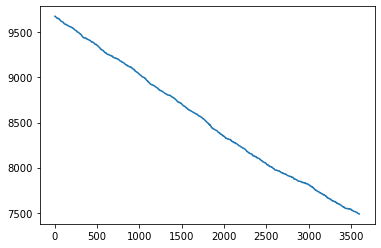

In [104]:
# Online EV numbers during hour 10
num = []
for i in range(3600):
    sse.g_u(t_now=10+i/3600)
    num.append(sse.ev.u.sum())
plt.plot(range(3600), num)

## SSM Matrix

In [ ]:
ev_pdf_name[0:2]

## Simulation

Issues: how to integerate the SSM when using ADNES?

flow_chart:
```{python}
prep grid data:
ADNES: topology,  gen. limits, ramp. limits, line limits,
Outside: gen. cost, ramp. cost,

for $t_{OPF}$ in T (interval: 5min; total: 1h; [n=12]):
    aggregate EV data (from SSM), generate $PR_{e,i,u,t}$
    Do OPF, generate $PG_{i, t}$, $PR_{g, i, u, t}$, $PR_{g, i, d, t}$

    for t in $t_{OPF}$ (interval: 4s; total: 5min; [n=75]):
        Update data into dynamic system:
            # Note, constant power model should be used in TDS.
            # Use TimeSeries as the load. 
            power change: TGOV1.paux0
            load change: 

        Run TDS: generate SFR mileage
```

Co-Sim list:
```{python}
for $t_{OPF}$ in T:
    EVA report $pru_{max}$ $prd_{max}$, eqn xxx
    TCC do OPF, eqn xxx
    Assign dispatch signal to generation units

    for t in $t_{AGC}$:
        Assign AGC signal to AGC units
        Run TDS
```